In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
# !pip install matplotlib==3.1.1 # Issue with last version bar plots

<IPython.core.display.Javascript object>

In [25]:
import sys

sys.path.insert(0, "../")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display

from scipy import signal
from scipy.ndimage.filters import gaussian_filter1d

from tqdm import tqdm_notebook

<IPython.core.display.Javascript object>

## Load data

In [4]:
# read data
X_train = np.load("../data/DOCC10_train/DOCC10_Xtrain.npy")
X_test = np.load("../data/DOCC10_test/DOCC10_Xtest.npy")
Y_train_df = pd.read_csv("../data/DOCC10_train/DOCC10_Ytrain.csv", index_col=0)

# Shift indexes
Y_train_df.index = Y_train_df.index - 20960

all_classes = list(set(Y_train_df.TARGET.values))

print("X train", X_train.shape, "Y_train", Y_train_df.shape, "X_test", X_test.shape)

X train (113120, 8192) Y_train (113120, 1) X_test (20960, 8192)


<IPython.core.display.Javascript object>

## Segment clicks 

In [5]:
def get_center(x_r):
    # Parameters
    cutoff = 10000
    win_size = 50
    gaussian_std = 5
    fs = 200000
    nyq = fs // 2
    order = 2
    normal_cutoff = cutoff / nyq

    # Butterworth highpass filter
    b, a = signal.butter(order, normal_cutoff, btype="high", analog=False)
    x_h = signal.filtfilt(b, a, x_r)

    # Wiener filter
    x_w = signal.wiener(x_h, mysize=win_size)

    # Gaussian filter
    x_g = gaussian_filter1d(np.abs(x_w), gaussian_std)

    # Argmax of the resulting signal
    center = x_g.argmax()

    return center

<IPython.core.display.Javascript object>

In [6]:
def show_centers(n_plots, classes):
    fig, axes = plt.subplots(
        n_plots, len(classes), figsize=(2 * len(classes), 2 * n_plots)
    )
    for j in range(len(classes)):
        X_sub = X_train[(Y_train_df == classes[j]).values.flatten()]
        axes[0, j].set_title(classes[j])
        for i in range(n_plots):
            idx = np.random.randint(len(X_sub))
            center = get_center(X_sub[idx])
            axes[i, j].plot(X_sub[idx])
            axes[i, j].axvline(x=center, color="red")
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
    plt.show()

<IPython.core.display.Javascript object>

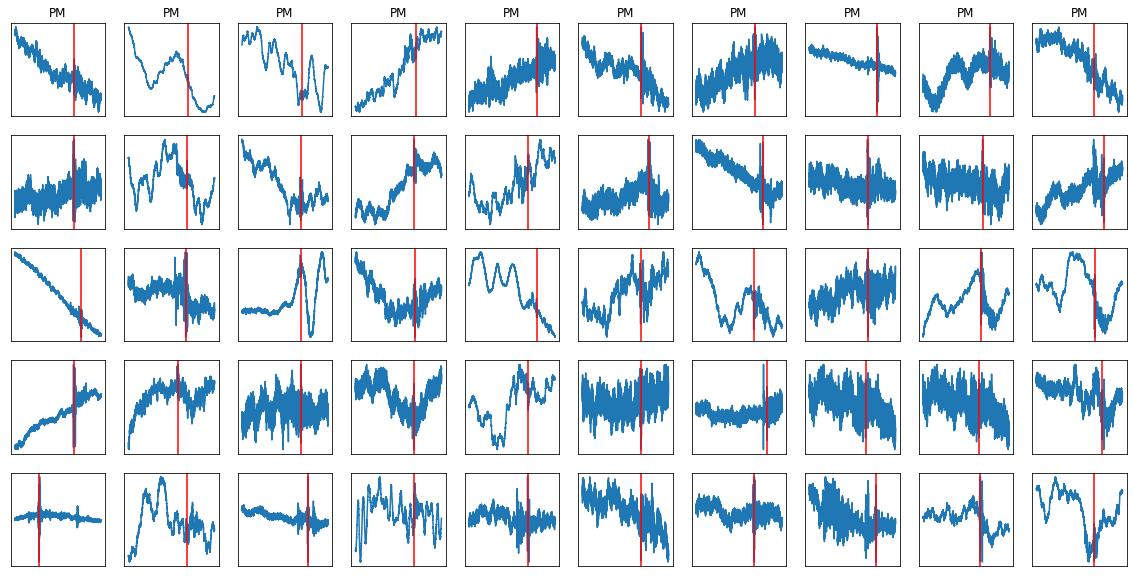

<IPython.core.display.Javascript object>

In [7]:
show_centers(5, ["PM"] * 10)

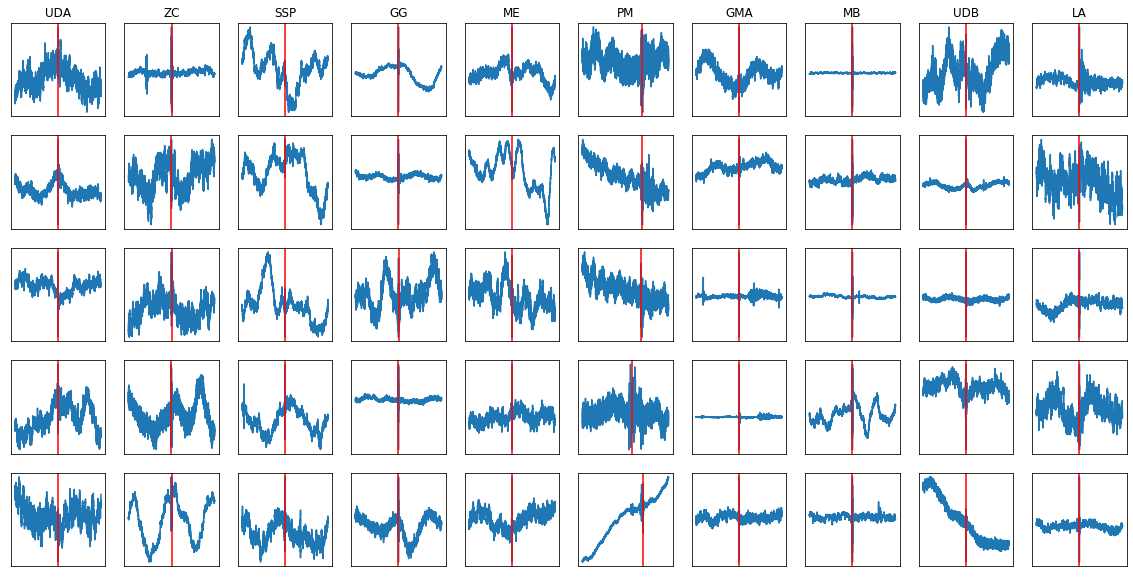

<IPython.core.display.Javascript object>

In [8]:
show_centers(5, all_classes)

In [9]:
def segment_clicks(x, cls=None, width=2 ** 8):
    T = len(x)
    assert width < T
    if cls == "PM":
        center = get_center(x)
    else:
        center = 2 ** 12
    if center - width // 2 < 0:
        min_t = 0
        max_t = width
    elif center + width // 2 >= T:
        min_t = -width
        max_t = T
    else:
        min_t = center - width // 2
        max_t = center + width // 2
    x_sub = x[min_t:max_t]
    assert len(x_sub) == width
    return x_sub

<IPython.core.display.Javascript object>

## Spectral features

### Feature: centered power spectrum bins

In [10]:
def get_power_spectrum(x, n_fft=64):
    n_fft = 64
    cutoff = 10000
    f_sampling = 200000
    window = signal.get_window(("gaussian", 30), n_fft)

    f, pspec = signal.welch(x, f_sampling, window, n_fft, scaling="spectrum")

    # Keep only freq > 10kHz
    pspec = pspec[f > cutoff]
    f = f[f > cutoff]
    return f, pspec

<IPython.core.display.Javascript object>

In [11]:
def show_temporal(x, vert=[]):
    plt.figure(figsize=(10, 5))
    plt.title("Signal")
    plt.plot(x)
    plt.yticks([])
    for v in vert:
        plt.axvline(x=v, color="red")
    plt.show()


def show_power_spectrum(frequencies, power_spectrum):
    plt.figure(figsize=(10, 5))
    plt.title("Power spectrum")
    N = len(frequencies)
    ind = np.arange(N)
    delta = frequencies[1] - frequencies[0]
    xlabels = (frequencies - delta / 2).astype(int)
    plt.bar(x=ind, height=power_spectrum)
    plt.xticks(ind, xlabels, rotation=45)
    plt.yticks([])
    plt.show()

<IPython.core.display.Javascript object>

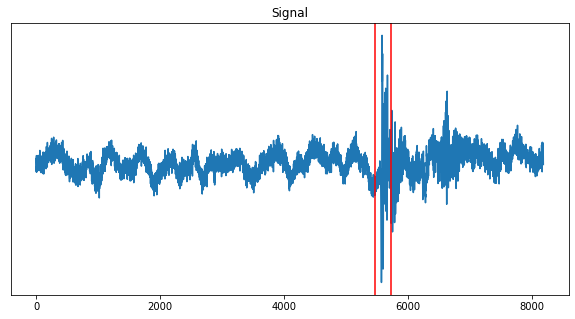

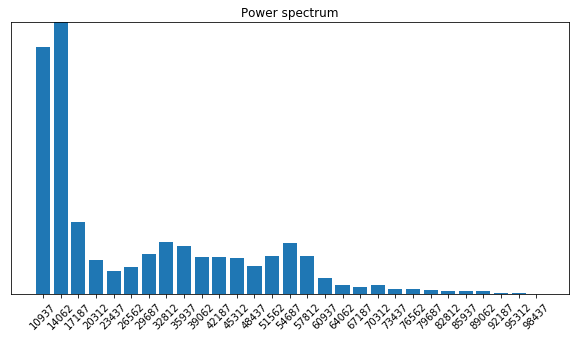

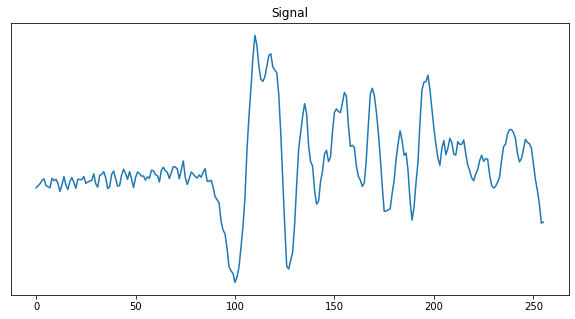

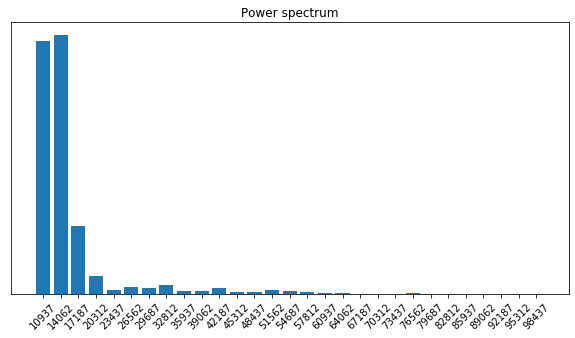

<IPython.core.display.Javascript object>

In [12]:
# Test
x_idx = 90496
x = X_train[x_idx]
x_cls = Y_train_df.loc[x_idx].TARGET
f, ps = get_power_spectrum(x, n_fft=64)
x_c = segment_clicks(x, cls=x_cls, width=2 ** 8)
f_c, ps_c = get_power_spectrum(x_c, n_fft=64)

show_temporal(x, [get_center(x) - 2 ** 7, get_center(x) + 2 ** 7])
show_power_spectrum(f, ps)
show_temporal(x_c)
show_power_spectrum(f_c, ps_c)

In [13]:
def show_power_spectrum_per_class(n_plots, classes):
    fig, axes = plt.subplots(
        n_plots, len(classes), figsize=(2 * len(classes), 2 * n_plots)
    )
    for j, cls in enumerate(classes):
        X_sub = X_train[(Y_train_df == classes[j]).values.flatten()]
        axes[0, j].set_title(classes[j])
        for i in range(n_plots):
            idx = np.random.randint(len(X_sub))
            x = X_sub[idx]
            x_c = segment_clicks(x, cls, width=2 ** 9)
            f_c, ps_c = get_power_spectrum(x_c, n_fft=64)
            # axes[i, j].plot(f_c, ps_c)
            axes[i, j].bar(x=1.5 * np.arange(len(f_c)), height=ps_c)
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
    plt.show()

<IPython.core.display.Javascript object>

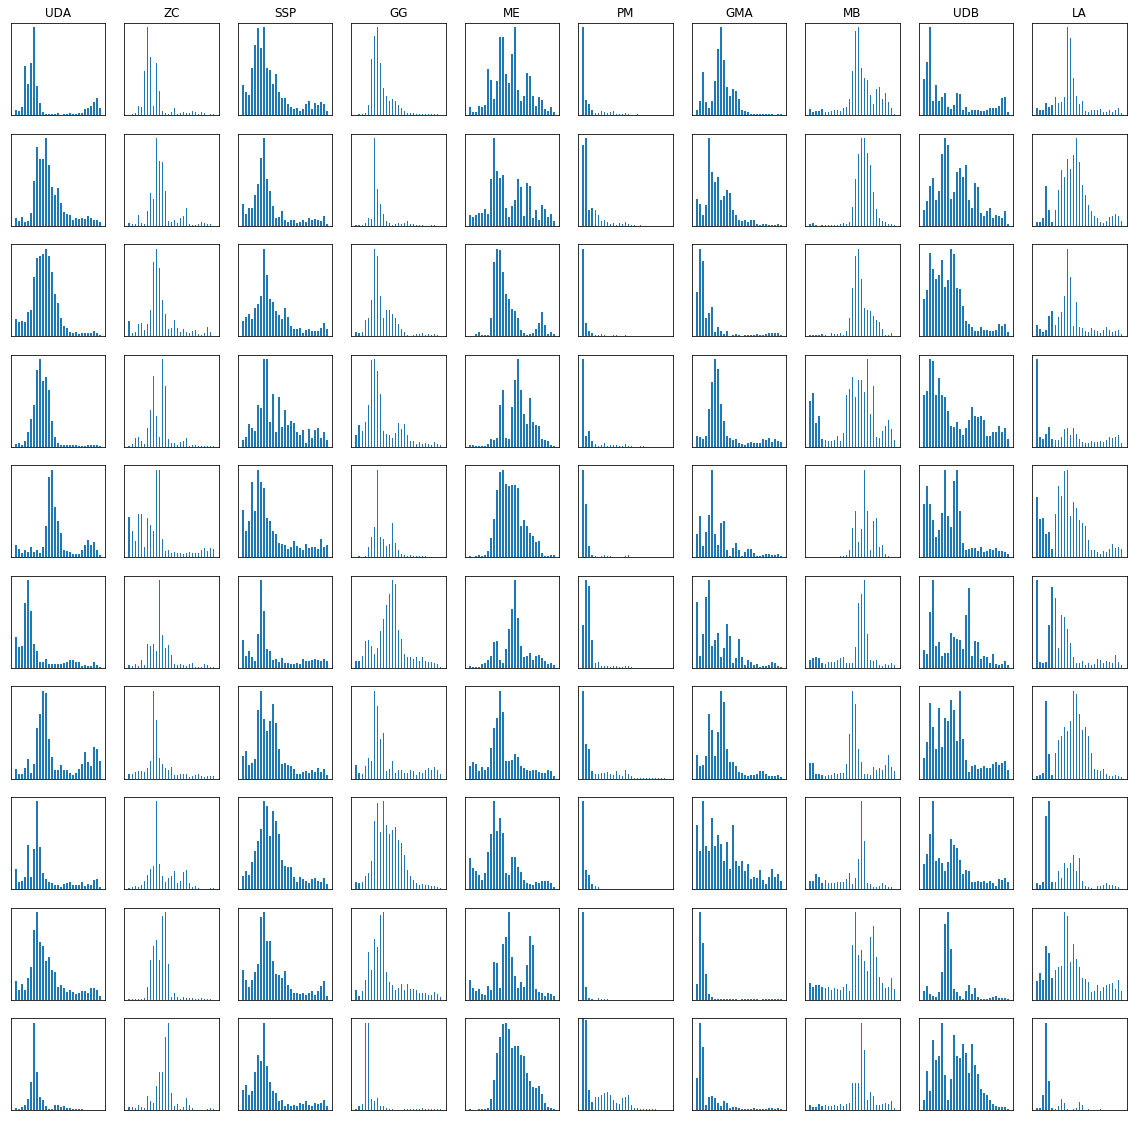

<IPython.core.display.Javascript object>

In [14]:
show_power_spectrum_per_class(10, all_classes)

### Feature: spectral width

In [15]:
def spectral_width(ps, ratio=0.5):
    pmax = ps.max()
    thresh = ratio * pmax
    width = (ps > thresh).sum()
    total = ps.sum()
    norm_width = width / total
    return norm_width

<IPython.core.display.Javascript object>

## Wavelets

In [16]:
import pywt
import scaleogram as scg

<IPython.core.display.Javascript object>

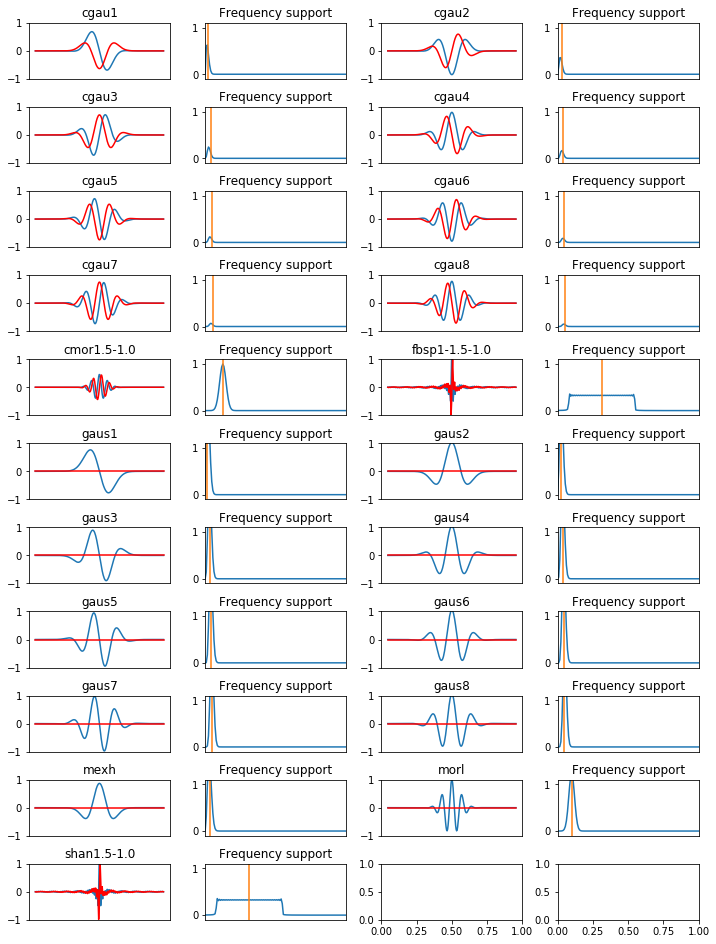

<IPython.core.display.Javascript object>

In [33]:
scg.plot_wavelets()

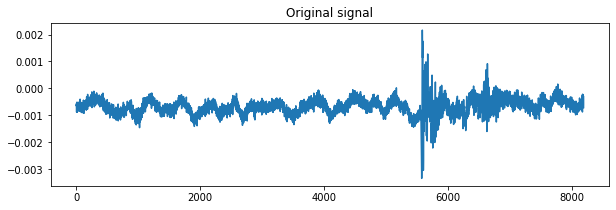

<IPython.core.display.Javascript object>

In [26]:
s = X_train[90496]
fig, ax = plt.subplots(figsize=(10, 3))
ax.set_title("Original signal")
ax.plot(s)
plt.show()

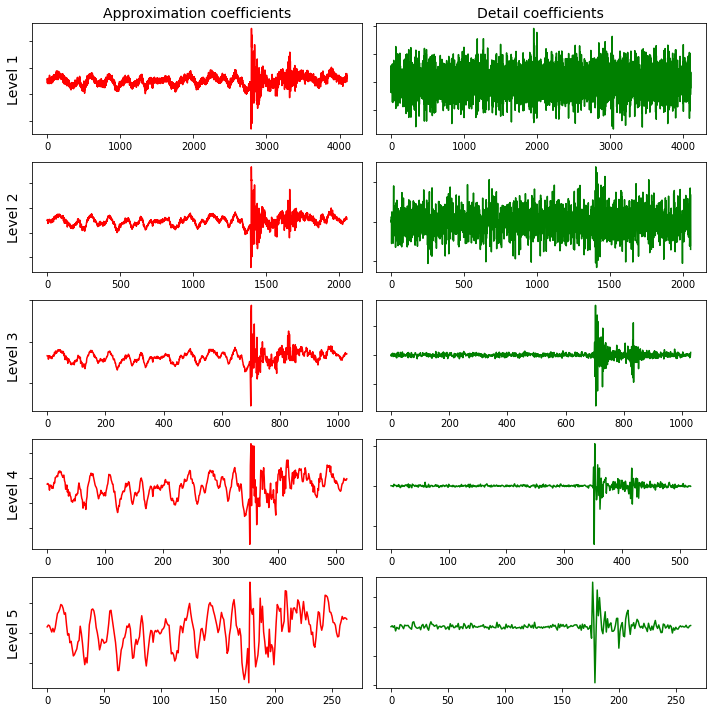

<IPython.core.display.Javascript object>

In [27]:
data = s
waveletname = "sym5"

fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, "r")
    axarr[ii, 1].plot(coeff_d, "g")
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

In [72]:
help(scg.cws)

Help on function cws in module scaleogram.cws:

cws(time, signal=None, scales=None, wavelet=None, periods=None, spectrum='amp', coi=True, coikw=None, yaxis='period', cscale='linear', cmap='jet', clim=None, cbar='vertical', cbarlabel=None, cbarkw=None, xlim=None, ylim=None, yscale=None, xlabel=None, ylabel=None, title=None, figsize=None, ax=None)
    Build and displays the 2D spectrum for Continuous Wavelet Transform
    
    Call signatures::
    
        # build the CWT and displays the scaleogram
        ax = cws(signal)
        ax = cws(time, signal)
    
        # use a previously computed Continuous Wavelet Transform
        cwt = CWT(time, signal)
        ax  = cws(CWT)
    
    
    Arguments
    ----------
    
    - time : array of time/spatial domain locations
        Can be filled with signal values if this function is called with only
        one argument.
        This array should have a constant sampling rate for the spectrum to
        have sense. Missing time samples wi

<IPython.core.display.Javascript object>

In [67]:
def plot_scaleogram(s):
    # fs = 200000
    ns = len(s)
    time = np.arange(ns)

    # and a range of scales to perform the transform
    scales = scg.periods2scales(np.arange(1, 20))

    # plot the signal
    fig1, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    lines = ax1.plot(s)
    ax1.set_xlim(0, len(time))
    fig1.tight_layout()

    # and the scaleogram
    ax2 = scg.cws(s, scales=scales, figsize=(11.28, 5))
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>

In [79]:
def show_scaleogram_per_class(n_plots, classes):
    fig, axes = plt.subplots(
        n_plots, len(classes), figsize=(2 * len(classes), 2 * n_plots)
    )

    ns = len(s)
    time = np.arange(ns)
    scales = scg.periods2scales(np.arange(1, 20))

    for j, cls in enumerate(classes):
        X_sub = X_train[(Y_train_df == classes[j]).values.flatten()]
        for i in range(n_plots):
            idx = np.random.randint(len(X_sub))
            x = X_sub[idx]
            x_c = segment_clicks(x, cls, width=2 ** 8)
            scg.cws(x_c, scales=scales, ax=axes[i, j], cbar=None, title="")
            axes[i, j].bar(x=1.5 * np.arange(len(f_c)), height=ps_c)
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
        axes[0, j].set_title(classes[j])
    plt.show()

<IPython.core.display.Javascript object>

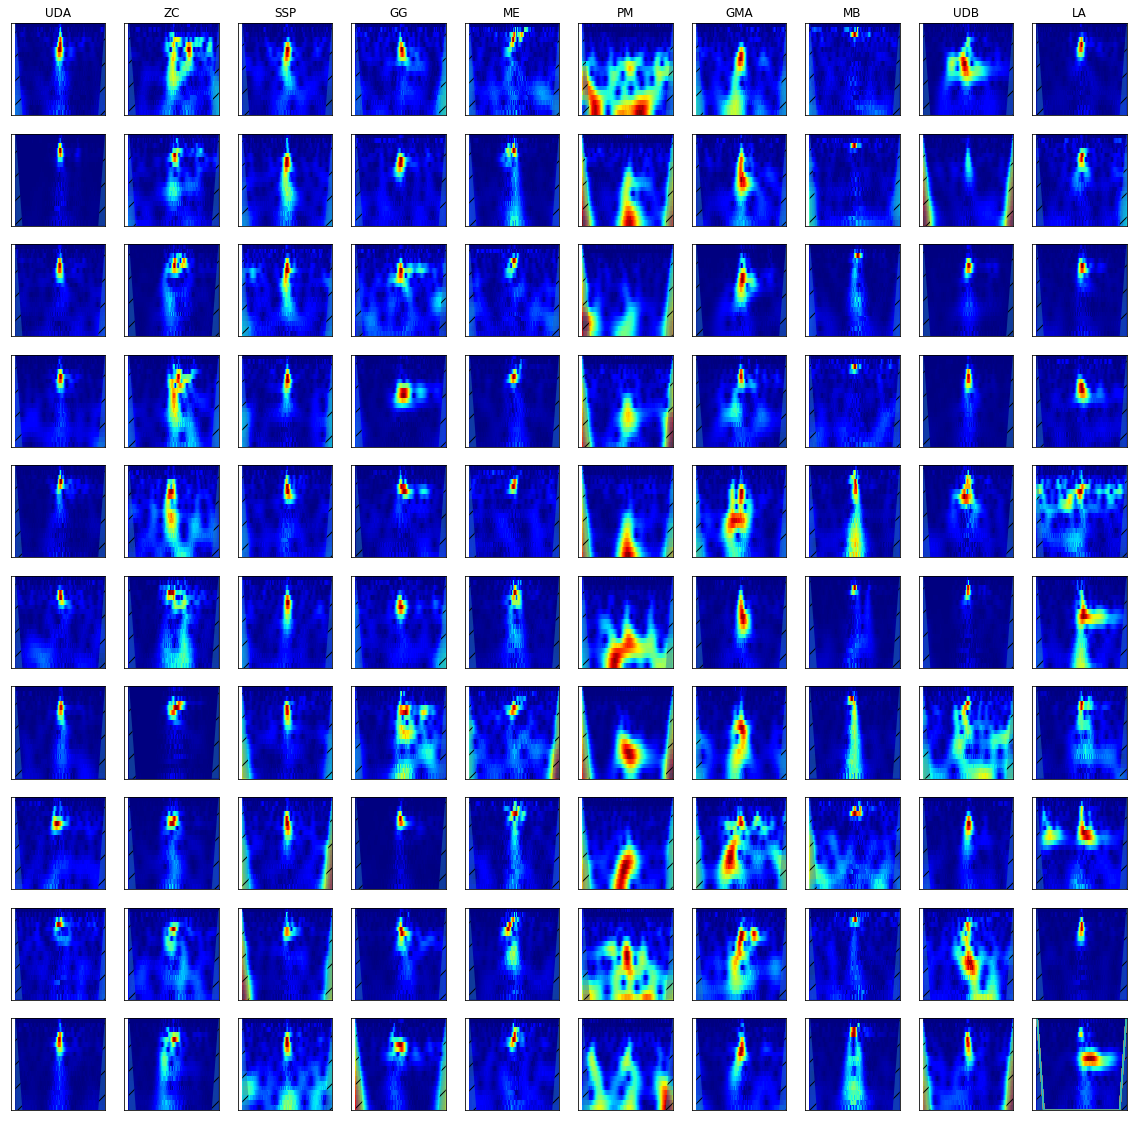

<IPython.core.display.Javascript object>

In [81]:
show_scaleogram_per_class(10, all_classes)

In [71]:
# waveletname = "cmor1-1.5"  # "cgau3"
# scg.set_default_wavelet(waveletname)

# for i in range(10):
#     idx_s = 30000 + i
#     s = X_train[idx_s]
#     print(Y_train_df.loc[idx_s].TARGET)
#     s = segment_clicks(s, cls="PM", width=2 ** 8)

#     plot_scaleogram(s)

<IPython.core.display.Javascript object>

In [90]:
time = np.arange(ns)
scales = scg.periods2scales(np.arange(1, 20))
data = X_train[0]
data = segment_clicks(data, cls="PM", width=2 ** 8)
cwt = scg.CWT(time, data, scales)

<IPython.core.display.Javascript object>

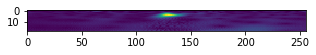

<IPython.core.display.Javascript object>

In [91]:
plt.figure(figsize=(5, 5))
plt.imshow(np.abs(cwt.coefs))

## Training a linear model

In [21]:
Y = Y_train_df.TARGET.tolist()

<IPython.core.display.Javascript object>

In [22]:
def build_ps_features():
    n_samples = X_train.shape[0]
    n_feats = 29 + 1
    X = np.zeros((n_samples, n_feats), dtype=np.float32)
    for i in tqdm_notebook(range(n_samples)):
        # Segment the click
        x = segment_clicks(X_train[i], cls=Y[i], width=2 ** 8)
        # Compute its power spectrum
        _, ps = get_power_spectrum(x, n_fft=64)
        # Divide it by Pmax
        ps = ps / ps.max()
        # Add the spectral width
        sw = spectral_width(ps)
        X[i, 0:29] = ps
        X[i, 29:] = sw
    return X

<IPython.core.display.Javascript object>

In [39]:
X = build_ps_features()
print(X.shape)

/home/mathieu/.envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



(113120, 30)


<IPython.core.display.Javascript object>

In [40]:
# !pip install --upgrade sklearn # requires scikit learn 0.22
from sklearn.preprocessing import StandardScaler, Normalizer, FunctionTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    plot_confusion_matrix,
    classification_report,
)

<IPython.core.display.Javascript object>

In [41]:
# Stratified split
X_spec_train, X_spec_val, Y_train, Y_val = train_test_split(
    X, Y, stratify=Y, test_size=0.15
)
print(f"Train size: {len(X_spec_train)}, val size: {len(X_spec_val)}")

Train size: 96152, val size: 16968


<IPython.core.display.Javascript object>

In [42]:
def normalize(X_un_train, X_un_val, norm="unit"):
    if norm == "standard":
        scaler_cls = StandardScaler()
    elif norm == "unit":
        scaler_cls = Normalizer()
    else:
        scaler_cls = FunctionTransformer()  # Identity

    scaler = scaler_cls.fit(X_spec_train)

    X_sc_train = scaler.transform(X_spec_train)
    X_sc_val = scaler.transform(X_spec_val)
    return X_sc_train, X_sc_val

<IPython.core.display.Javascript object>

In [43]:
# Scaling the data
norm = None  # "unit"

X_sc_spec_train, X_sc_spec_val = normalize(X_spec_train, X_spec_val, norm)

<IPython.core.display.Javascript object>

In [44]:
# C_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# for C in C_list:
#     # Logistic regression
#     model = LogisticRegression(
#         C=C,
#         verbose=0,
#         solver="lbfgs",
#         max_iter=5000,
#         multi_class="multinomial",
#         random_state=0,
#         # tol=0.0001,
#     )
#     model.fit(X_sc_spec_train, Y_train)

#     # Val set
#     train_acc = model.score(X_sc_spec_train, Y_train)
#     val_acc = model.score(X_sc_spec_val, Y_val)
#     print("C:", C)
#     print(f"Train acc: {train_acc:.4f}")
#     print(f"Val acc: {val_acc:.4f}")

<IPython.core.display.Javascript object>

In [45]:
# Logistic regression
model = LogisticRegression(
    C=50,
    verbose=1,
    solver="lbfgs",
    max_iter=5000,
    multi_class="multinomial",
    random_state=0,
    tol=0.0001,
)
model.fit(X_sc_spec_train, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min finished


LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [46]:
# Val set
train_acc = model.score(X_sc_spec_train, Y_train)
val_acc = model.score(X_sc_spec_val, Y_val)

print(f"Train acc: {train_acc:.4f}")
print(f"Val acc: {val_acc:.4f}")

Train acc: 0.6375
Val acc: 0.6342


<IPython.core.display.Javascript object>

In [47]:
print("Validation")
print(classification_report(Y_val, model.predict(X_sc_spec_val)))

Validation
              precision    recall  f1-score   support

          GG       0.49      0.55      0.52      1697
         GMA       0.65      0.63      0.64      1697
          LA       0.56      0.46      0.50      1697
          MB       0.92      0.97      0.94      1697
          ME       0.63      0.69      0.66      1697
          PM       0.97      0.97      0.97      1697
         SSP       0.59      0.72      0.65      1696
         UDA       0.41      0.32      0.36      1697
         UDB       0.51      0.41      0.45      1697
          ZC       0.54      0.63      0.58      1696

    accuracy                           0.63     16968
   macro avg       0.63      0.63      0.63     16968
weighted avg       0.63      0.63      0.63     16968



<IPython.core.display.Javascript object>

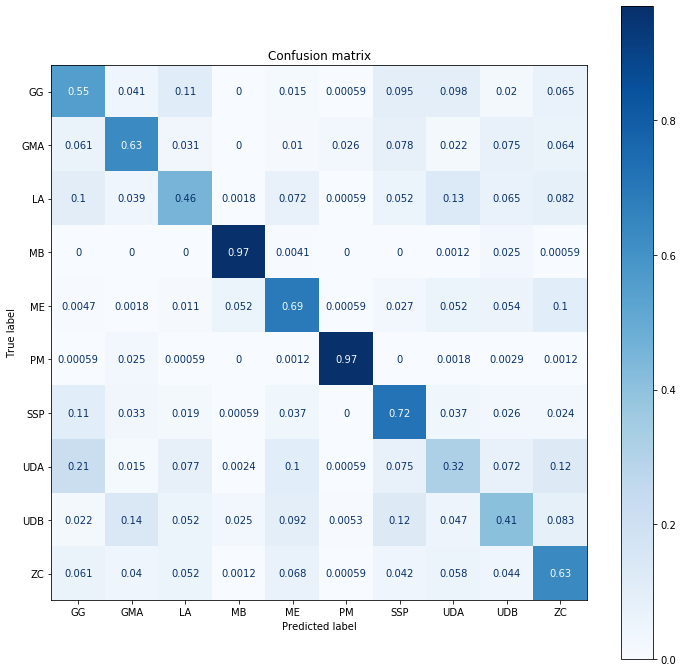

<IPython.core.display.Javascript object>

In [48]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title("Confusion matrix")
plot_confusion_matrix(
    model, X_sc_spec_val, Y_val, cmap=plt.cm.Blues, normalize="true", ax=ax
)

Best: 0.64 with C=50 and unit